# Market Efficiency Analysis

This notebook queries the local API at `http://127.0.0.1:8085` for market efficiency over the past week: high-level stats, efficiency and lock-count aggregates (daily/hourly), and non-most-profitable requests with readable `more_profitable_sample` drill-down.

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import ipywidgets as widgets
from datetime import datetime, timedelta, timezone
from IPython.display import display, HTML

API_BASE_URL = "http://127.0.0.1:8085"
LOOKBACK_DAYS = 7
API_SLEEP_SEC = 0.2
RATE_LIMIT_BACKOFF_SEC = 60
MAX_RETRIES = 5

now = datetime.now(timezone.utc)
cutoff = now - timedelta(days=LOOKBACK_DAYS)
cutoff_ts = int(cutoff.timestamp())
now_ts = int(now.timestamp())

plt.style.use("default")
%matplotlib inline

print(f"API Base URL: {API_BASE_URL}")
print(f"Now (UTC):    {now.isoformat()}")
print(f"Cutoff (UTC): {cutoff.isoformat()} (timestamp: {cutoff_ts})")

API Base URL: http://127.0.0.1:8085
Now (UTC):    2026-02-18T21:19:04.601045+00:00
Cutoff (UTC): 2026-02-11T21:19:04.601045+00:00 (timestamp: 1770844744)


## API client and fetchers

Rate-limited GET helper with retries; paginated fetchers for efficiency snapshot, aggregates, and requests.

In [6]:
VARIANTS = {
    "Raw": {"type": "raw"},
    "Gas-Adjusted": {"type": "gas_adjusted"},
    "Gas-Adj + Exclusions": {"type": "gas_adjusted_with_exclusions"},
}


def api_get(path, params=None, timeout=30):
    url = f"{API_BASE_URL.rstrip('/')}{path}"
    for attempt in range(MAX_RETRIES):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            if r.status_code in (403, 429):
                print(f"  Rate limited (HTTP {r.status_code}), waiting {RATE_LIMIT_BACKOFF_SEC}s...")
                time.sleep(RATE_LIMIT_BACKOFF_SEC)
                continue
            r.raise_for_status()
            time.sleep(API_SLEEP_SEC)
            return r.json()
        except requests.exceptions.RequestException as e:
            if attempt == MAX_RETRIES - 1:
                raise
            time.sleep(RATE_LIMIT_BACKOFF_SEC)
    raise RuntimeError("api_get: max retries exceeded")


def fetch_efficiency_snapshot(variant_params=None):
    params = dict(variant_params or {})
    data = api_get("/v1/market/efficiency", params=params or None)
    return data


def fetch_efficiency_aggregates(granularity, after_ts=None, limit=1000, variant_params=None):
    after_ts = after_ts if after_ts is not None else cutoff_ts
    all_data = []
    cursor = None
    while True:
        params = {"granularity": granularity, "limit": limit, "sort": "asc", "after": after_ts}
        params.update(variant_params or {})
        if cursor:
            params["cursor"] = cursor
        data = api_get("/v1/market/efficiency/aggregates", params=params)
        items = data.get("data", [])
        all_data.extend(items)
        if not data.get("has_more", False):
            break
        cursor = data.get("next_cursor")
        if not cursor:
            break
    if not all_data:
        return pd.DataFrame()
    df = pd.DataFrame(all_data)
    # Normalize camelCase to snake_case for known fields
    renames = {
        "efficiencyRate": "efficiency_rate",
        "numMostProfitableLocked": "num_most_profitable_locked",
        "numNotMostProfitableLocked": "num_not_most_profitable_locked",
    }
    for old_name, new_name in renames.items():
        if old_name in df.columns and new_name not in df.columns:
            df[new_name] = df[old_name]
    # Build datetime from various possible timestamp columns
    if "datetime" not in df.columns:
        if "period_timestamp_iso" in df.columns:
            df["datetime"] = pd.to_datetime(df["period_timestamp_iso"])
        elif "period_timestamp" in df.columns:
            df["datetime"] = pd.to_datetime(df["period_timestamp"], unit="s")
        elif "timestamp_iso" in df.columns:
            df["datetime"] = pd.to_datetime(df["timestamp_iso"])
        elif "timestamp" in df.columns:
            df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
        elif "period_start_iso" in df.columns:
            df["datetime"] = pd.to_datetime(df["period_start_iso"])
        elif "period_start" in df.columns:
            df["datetime"] = pd.to_datetime(df["period_start"], unit="s")
        elif "ts" in df.columns:
            df["datetime"] = pd.to_datetime(df["ts"], unit="s")
        elif "bucket_start" in df.columns:
            df["datetime"] = pd.to_datetime(df["bucket_start"], unit="s")
        elif "start_time_iso" in df.columns:
            df["datetime"] = pd.to_datetime(df["start_time_iso"])
        elif "date" in df.columns:
            df["datetime"] = pd.to_datetime(df["date"])
    if "datetime" in df.columns:
        if df["datetime"].dt.tz is not None:
            df["datetime"] = df["datetime"].dt.tz_convert("UTC").dt.tz_localize(None)
        df = df.sort_values("datetime").reset_index(drop=True)
    return df


def fetch_efficiency_requests_all_pages(limit=500):
    all_items = []
    cursor = None
    while True:
        params = {"limit": limit, "after": cutoff_ts}
        if cursor:
            params["cursor"] = cursor
        data = api_get("/v1/market/efficiency/requests", params=params)
        items = data.get("data", [])
        all_items.extend(items)
        if not data.get("has_more", False):
            break
        cursor = data.get("next_cursor")
        if not cursor:
            break
    return all_items

## High-level efficiency stats (past week)

In [7]:
snapshots = {}
for vname, vparams in VARIANTS.items():
    snapshots[vname] = fetch_efficiency_snapshot(variant_params=vparams)

for vname, snapshot in snapshots.items():
    print(f"\n--- {vname} ---")
    for k, v in snapshot.items():
        if k not in ("data", "request_id"):
            print(f"  {k}: {v}")
    if "data" in snapshot:
        for k, v in snapshot["data"].items():
            print(f"  data.{k}: {v}")


--- Raw ---
  latest_hourly_efficiency_rate: 0.7931034482758621
  latest_daily_efficiency_rate: 0.9087947882736156
  total_requests_analyzed: 20167
  most_profitable_locked: 12618
  not_most_profitable_locked: 7549
  last_updated: 2026-02-18T19:00:00Z

--- Gas-Adjusted ---
  latest_hourly_efficiency_rate: 0.7241379310344828
  latest_daily_efficiency_rate: 0.7882736156351792
  total_requests_analyzed: 20167
  most_profitable_locked: 4369
  not_most_profitable_locked: 15798
  last_updated: 2026-02-18T19:00:00Z

--- Gas-Adj + Exclusions ---
  latest_hourly_efficiency_rate: 0.7241379310344828
  latest_daily_efficiency_rate: 0.7882736156351792
  total_requests_analyzed: 20167
  most_profitable_locked: 4369
  not_most_profitable_locked: 15798
  last_updated: 2026-02-18T19:00:00Z


## Fetch efficiency aggregates (daily and hourly) for all variants

In [8]:
agg_daily = {}
agg_hourly = {}
for vname, vparams in VARIANTS.items():
    agg_daily[vname] = fetch_efficiency_aggregates("daily", variant_params=vparams)
    agg_hourly[vname] = fetch_efficiency_aggregates("hourly", variant_params=vparams)
    print(f"{vname}: daily={len(agg_daily[vname])} rows, hourly={len(agg_hourly[vname])} rows")

sample_df = next((df for df in agg_daily.values() if len(df) > 0), pd.DataFrame())
if len(sample_df) > 0:
    print(f"Columns: {list(sample_df.columns)}")

Raw: daily=7 rows, hourly=166 rows
Gas-Adjusted: daily=7 rows, hourly=166 rows
Gas-Adj + Exclusions: daily=7 rows, hourly=166 rows
Columns: ['period_timestamp', 'period_timestamp_iso', 'num_most_profitable_locked', 'num_not_most_profitable_locked', 'efficiency_rate', 'datetime']


## Efficiency rate over time (daily and hourly) -- all variants

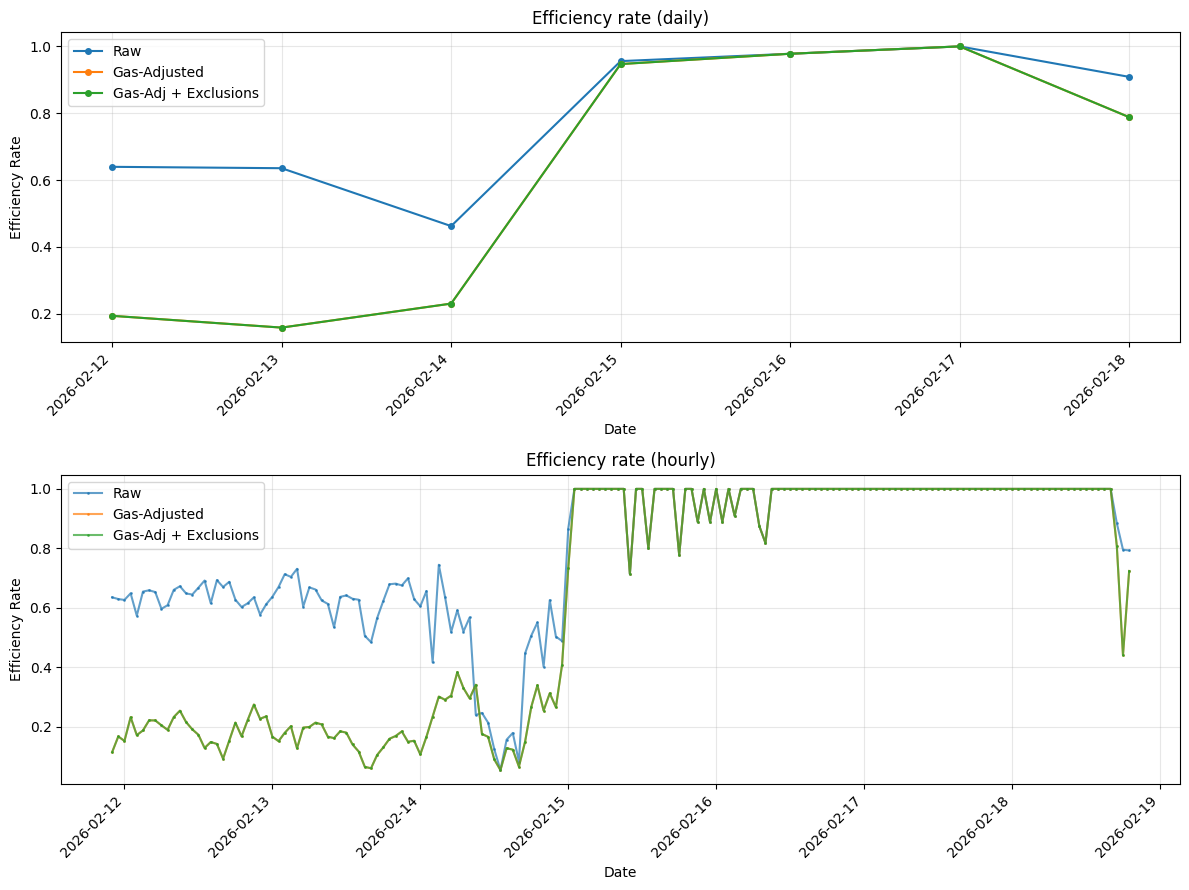

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

for vname in VARIANTS:
    df = agg_daily[vname]
    if "efficiency_rate" in df.columns and "datetime" in df.columns:
        axes[0].plot(df["datetime"], df["efficiency_rate"], marker="o", markersize=4, label=vname)
axes[0].set_title("Efficiency rate (daily)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Efficiency Rate")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha="right")

for vname in VARIANTS:
    df = agg_hourly[vname]
    if "efficiency_rate" in df.columns and "datetime" in df.columns:
        axes[1].plot(df["datetime"], df["efficiency_rate"], marker=".", markersize=2, alpha=0.7, label=vname)
axes[1].set_title("Efficiency rate (hourly)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Efficiency Rate")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Most profitable vs not most profitable locked (daily and hourly) -- all variants

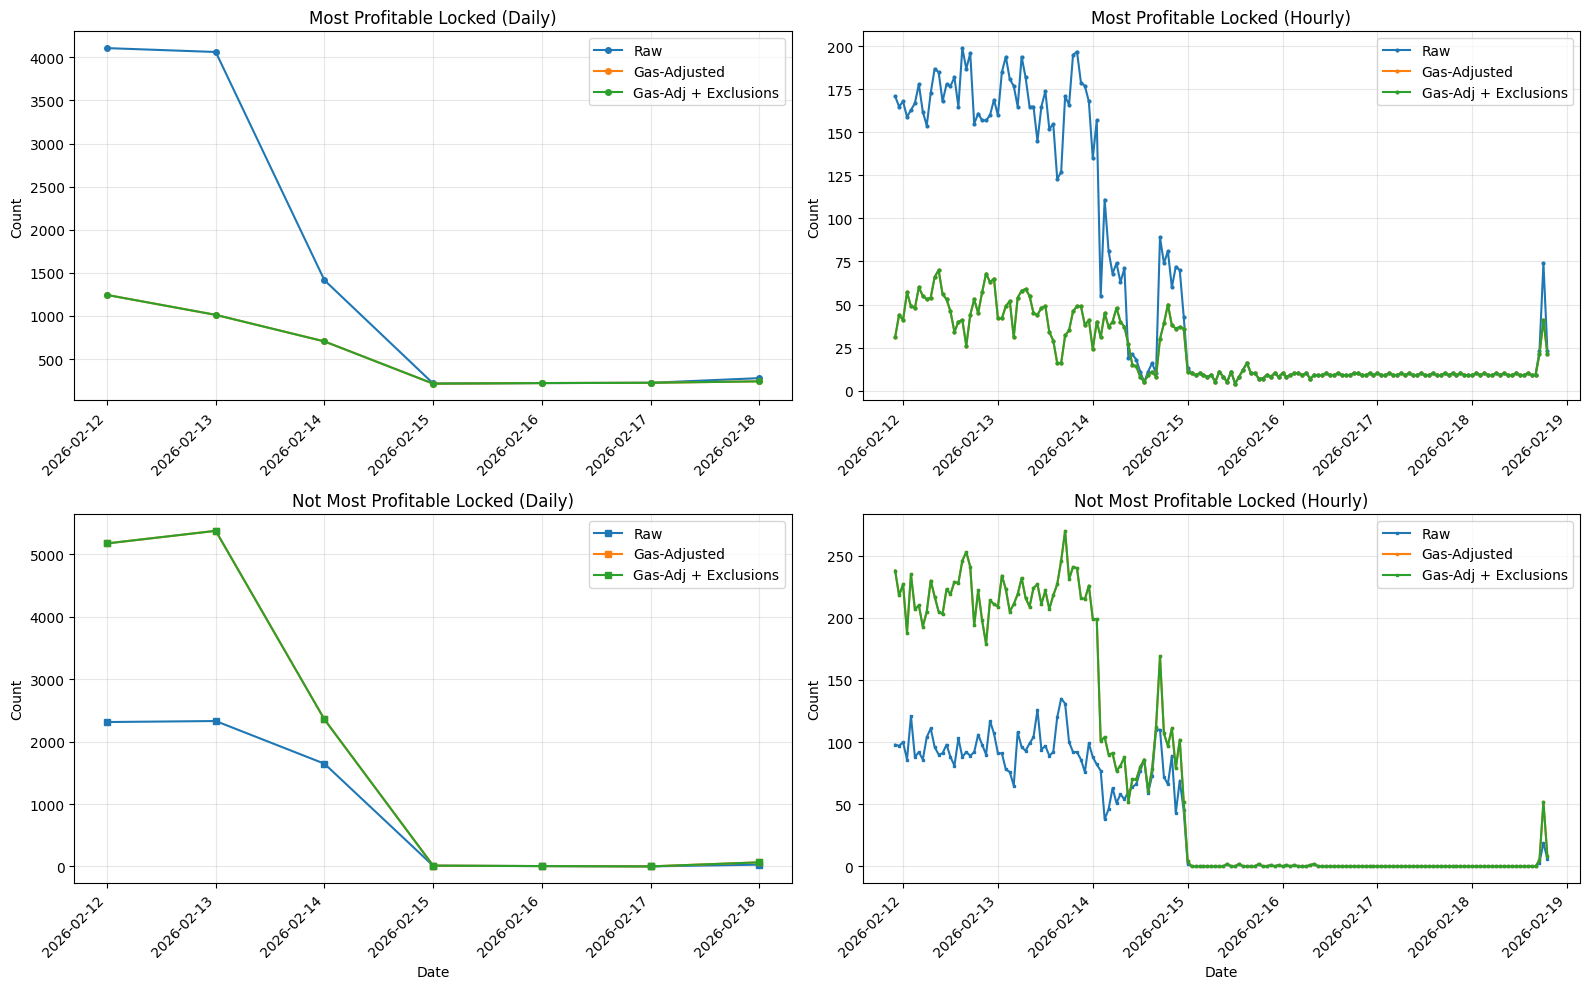

In [10]:
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))

for col_idx, (agg_dict, gran_label) in enumerate([(agg_daily, "Daily"), (agg_hourly, "Hourly")]):
    ms = 4 if gran_label == "Daily" else 2
    for vname in VARIANTS:
        df = agg_dict[vname]
        if "datetime" not in df.columns:
            continue
        if "num_most_profitable_locked" in df.columns:
            axes2[0, col_idx].plot(df["datetime"], df["num_most_profitable_locked"],
                                   marker="o", markersize=ms, label=vname)
        if "num_not_most_profitable_locked" in df.columns:
            axes2[1, col_idx].plot(df["datetime"], df["num_not_most_profitable_locked"],
                                   marker="s", markersize=ms, label=vname)

    axes2[0, col_idx].set_title(f"Most Profitable Locked ({gran_label})")
    axes2[0, col_idx].set_ylabel("Count")
    axes2[0, col_idx].legend()
    axes2[0, col_idx].grid(True, alpha=0.3)
    plt.setp(axes2[0, col_idx].xaxis.get_majorticklabels(), rotation=45, ha="right")

    axes2[1, col_idx].set_title(f"Not Most Profitable Locked ({gran_label})")
    axes2[1, col_idx].set_xlabel("Date")
    axes2[1, col_idx].set_ylabel("Count")
    axes2[1, col_idx].legend()
    axes2[1, col_idx].grid(True, alpha=0.3)
    plt.setp(axes2[1, col_idx].xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Fetch efficiency requests (past week, all pages)

In [11]:
all_requests = fetch_efficiency_requests_all_pages()
all_requests = [r for r in all_requests if r.get("updated_at", 0) >= cutoff_ts or r.get("locked_at", 0) >= cutoff_ts]
print(f"Fetched {len(all_requests)} efficiency requests in the past {LOOKBACK_DAYS} days")

Fetched 17610 efficiency requests in the past 7 days


## Non-most-profitable requests: summary and more_profitable_sample drill-down

Summary counts for `is_most_profitable = false`, plus a dropdown to inspect each row's `more_profitable_sample`.

In [12]:
non_most_profitable = [r for r in all_requests if r.get("is_most_profitable") is False]

EXPLORER_BASE = "https://explorer.boundless.network/orders"

def request_id_to_hex(rid):
    try:
        return hex(int(rid))
    except (ValueError, TypeError):
        return str(rid)

print(f"Total requests: {len(all_requests)}")
print(f"Non-most-profitable: {len(non_most_profitable)}")
print(f"Most-profitable: {len(all_requests) - len(non_most_profitable)}")
if all_requests:
    rate = (len(all_requests) - len(non_most_profitable)) / len(all_requests)
    print(f"Efficiency rate: {rate:.4f}")

Total requests: 17610
Non-most-profitable: 6602
Most-profitable: 11008
Efficiency rate: 0.6251


In [13]:
def render_more_profitable_sample(sample):
    if sample is None:
        display(HTML("<em>No more_profitable_sample</em>"))
        return
    if isinstance(sample, str):
        try:
            sample = json.loads(sample)
        except (json.JSONDecodeError, TypeError):
            display(HTML(f"<pre>{sample[:2000]}{'...' if len(sample) > 2000 else ''}</pre>"))
            return
    if isinstance(sample, list) and sample and isinstance(sample[0], dict):
        df_sample = pd.DataFrame(sample)
        if "request_id" in df_sample.columns:
            df_sample["request_id_hex"] = df_sample["request_id"].apply(request_id_to_hex)
            df_sample["explorer_link"] = df_sample["request_id_hex"].apply(
                lambda h: f'<a href="{EXPLORER_BASE}/{h}?from=orders" target="_blank">{h}</a>'
            )
            cols = ["explorer_link"] + [c for c in df_sample.columns if c not in ("request_id", "request_id_hex", "explorer_link")]
            display(HTML(df_sample[cols].to_html(escape=False, index=True)))
        else:
            display(df_sample)
        return
    if isinstance(sample, (list, dict)):
        s = json.dumps(sample, indent=2)
        display(HTML("<pre>" + (s[:5000] + "..." if len(s) > 5000 else s) + "</pre>"))
        return
    display(HTML(f"<pre>{sample}</pre>"))


def on_select(change):
    if change["new"] is None or not non_most_profitable:
        return
    idx = change["new"]
    row = non_most_profitable[idx]
    sample = row.get("more_profitable_sample")
    rid_hex = request_id_to_hex(row.get("request_id", "N/A"))
    out.clear_output()
    with out:
        display(HTML(f'Request: <a href="{EXPLORER_BASE}/{rid_hex}?from=orders" target="_blank">{rid_hex}</a>'))
        render_more_profitable_sample(sample)


options = [f"{i}: {request_id_to_hex(r.get('request_id', 'N/A'))}" for i, r in enumerate(non_most_profitable)]
dropdown = widgets.Dropdown(options=[(opt, i) for i, opt in enumerate(options)] if options else [], description="Row:")
out = widgets.Output()
dropdown.observe(on_select, names="value")
display(widgets.VBox([dropdown, out]))
if non_most_profitable:
    dropdown.value = 0

## Summary

In [14]:
print(f"Total efficiency requests fetched (past {LOOKBACK_DAYS} days): {len(all_requests)}")
print(f"Non-most-profitable count: {len(non_most_profitable)}")
print(f"Date range: {cutoff.isoformat()} to {now.isoformat()}")

Total efficiency requests fetched (past 7 days): 17610
Non-most-profitable count: 6602
Date range: 2026-02-11T21:19:04.601045+00:00 to 2026-02-18T21:19:04.601045+00:00
